In [326]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import corner

In [327]:
same_dist = False # If true, will ignore choice of mu_2 and set it equal to mu_1
seed = 3221 # Set the seed of the rng

mu1 = 0 # true mean for cluster 1
C1 = 1 # true (co)cariance for cluster 1

mu2 = 5 # true mean for cluster 1
C2 = 1 # true (co)cariance for cluster 1



Nd1 = 200 # Number of samples to draw from the first cluster
Nd2 = 100 # Number of samples to draw from the second cluster

In [328]:
if same_dist:
    mu2 = np.copy(mu1)
    C2 = np.copy(C1)
    
if int(np.__version__[0]) < 2: # Using old numpy
    np.random.seed(seed)
    rng = np.random
else:
    rng = np.random.default_rng(seed=seed)
    
# Make these items compatible with rng.multivariate_normal
mu1 = np.atleast_1d(mu1)
mu2 = np.atleast_1d(mu2)

C1 = np.atleast_2d(C1)
C2 = np.atleast_2d(C2)

In [329]:
def update_pig(ng, n):
    """
    Update the mixture weights for each group based on the current
    number of data assigned to each group and total number of data.
    
    Parameters:
        ng (float, array):
            Number of elements assigned to each group. Is a float because labels are 'soft'
        n (int):
            Total number of data points.
            
    Returns:
        pig (float, array):
            The mixture weights -- may be interpreted in a hierarchical model as the prior
            probability that a data point falls within the respective cluster.
    """
    
    return ng / n

def update_mug(ng, zig, d):
    """
    Update the mean estimate for each cluster based on the current group membership.
    
    Parameters:
        ng (float, array):
            Number of data assigned to each cluster.
        zig (float, array):
            Indicator of cluster membership for each datum i.e. the soft labels.
        d (float, array):
            The data.
        
    Returns:
        mug (float, array):
            The means of the clusters.
    """
    return (d.T @ zig) / ng # Ndim X Ngroup

def update_Sig(ng, zig, mug, d):
    """
    Update the covariance matrices of each cluster.
    
    Parameters:
        ng (float, array):
            Number of data assigned to each cluster.
        zig (float, array):
            Indicator of cluster membership for each datum i.e. the soft labels.
        mug (float, array):
            The means of the clusters.
        d (float, array):
            The data.
    Returns:
        Sig (float, array):
            The covariance matrices for each group (just the variances if data are 1-dimensional)
    """
    res = d[:, None] - mug.T # Nobs X Ngroup X Ndim
    Sig = (zig[:, :, None, None] * (res[:, :, :, None] * res[:, :, None])).sum(axis=0) / ng[:, None, None] # Ngroup X Ndim X Ndim
    return Sig

def update_zig(pig, d, mug, Sig):
    """
    Update the cluster memberships of the data.
    
    Parameters:
        pig (float, array):
            The mixture weights -- may be interpreted in a hierarchical model as the prior
            probability that a data point falls within the respective cluster.
        d (float, array):
            The data.
        mug (float, array):
            The means of the clusters.
        Sig (float, array):
            The covariance matrices for each group (just the variances if data are 1-dimensional)
            
    Returns:
        zig (float, array):
            Indicator of cluster membership for each datum i.e. the soft labels.
    """
    Nobs = d.shape[0]
    Ng = len(pig)
    zig = np.zeros([Nobs, Ng])
    dens = np.zeros([Nobs, Ng])
    for g in range(Ng):
        dens[:, g] = multivariate_normal(mean=mug[:, g], cov=Sig[g]).pdf(d)
    zig_num = pig * dens
    zig_den = zig_num.sum(axis=1)
    
    zig = zig_num / zig_den[:, None]
    ng = zig.sum(axis=0)
    
    return zig, ng

def do_EM(d, zig=None, Niter=int(1e4), Ng=2):
    """
    Do the EM algorithm.
    
    Parameters:
        d (float, array):
            The data.
        zig (None or float_array):
            Initial cluster membership array -- starts somewhere random if set to None (default)
        Niter (int):
            The number of iterations to perform the EM algorithm. 
        Ng (int):
            The number of groups.
    
    Returns:
        pig (float, array):
            Marginal mode of the mixture weights -- may be interpreted in a hierarchical model 
            as the prior probability that a data point falls within the respective cluster.
        mug (float, array):
            Marginal mode for the means of the clusters.
        Sig (float, array):
            Marginal mode for the covariance matrices for each group (just the variances if data are 1-dimensional)
        zig (float, array):
            Conditional expectation of indicator of cluster membership for each datum i.e. the soft labels.
        ng (float, array):
            Number of data assigned to each cluster.
    """
    n = d.shape[0]
    if zig is None:
        zig = rng.dirichlet(np.full(Ng, 1), size=n)
        ng = np.sum(zig, axis=0)
    
    for iter_ind in range(Niter):
        pig = update_pig(ng, n)
        mug = update_mug(ng, zig, d)
        Sig = update_Sig(ng, zig, mug, d)
        zig, ng = update_zig(pig, d, mug, Sig)
    
    return pig, mug, Sig, zig, ng
        
        

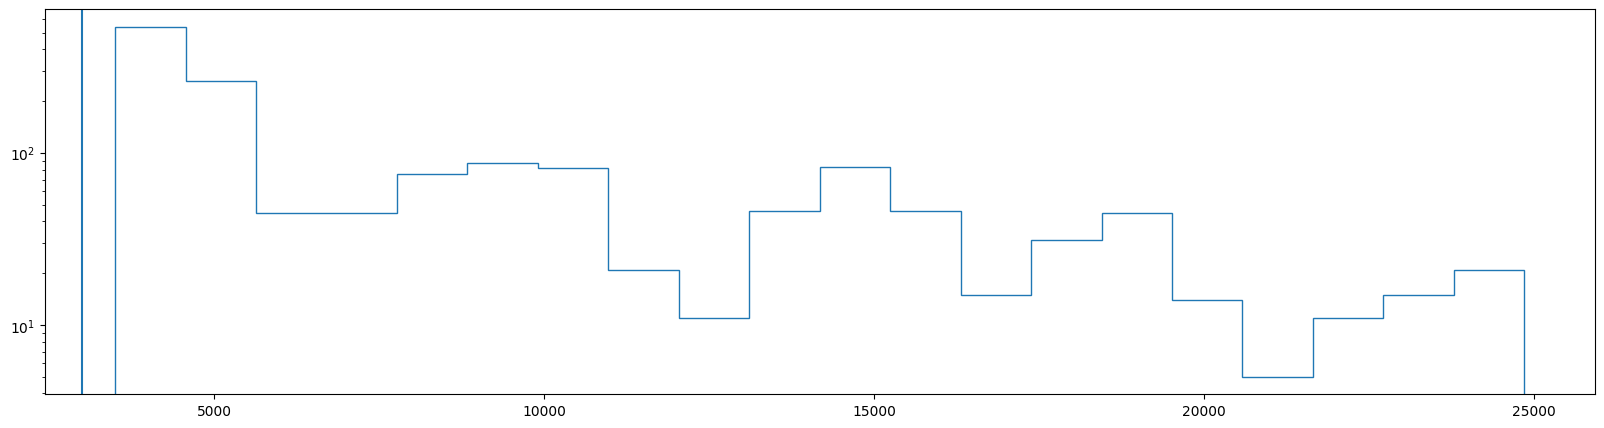

In [330]:
amps = np.load("Data/raw_amps_p2.npz")
TV6 = np.sort(amps['arr_0'])
TV7 = np.sort(amps['arr_1'])
TV8 = np.sort(amps['arr_2'])
TV9 = np.sort(amps['arr_3'])
all_TV = np.sort(np.concatenate((TV6,TV7,TV8,TV9)))
outliers = np.sort(all_TV[all_TV > 3000])
plt.figure(figsize=(20, 5))
plt.hist(outliers, bins='auto', histtype='step', density=False)
plt.yscale('log')
plt.axvline(x=3000)

In [331]:
pig, mug, Sig, zig, ng = do_EM(np.vstack(outliers), Niter=int(1e4), Ng=5)

In [332]:
print(f"The means for my groups were: {mug}")

The means for my groups were: [[ 4320.08799415  8616.56640229 14575.68402591 18886.60479687
  10194.00446732]]


In [333]:
# Lots of indexing because I've made the code scalable to higher dimensions

print(f"The variances for my groups were: {Sig}")

The variances for my groups were: [[[3.34319126e+05]]

 [[3.16303961e+06]]

 [[4.37938599e+05]]

 [[1.01704838e+07]]

 [[6.54807471e+03]]]


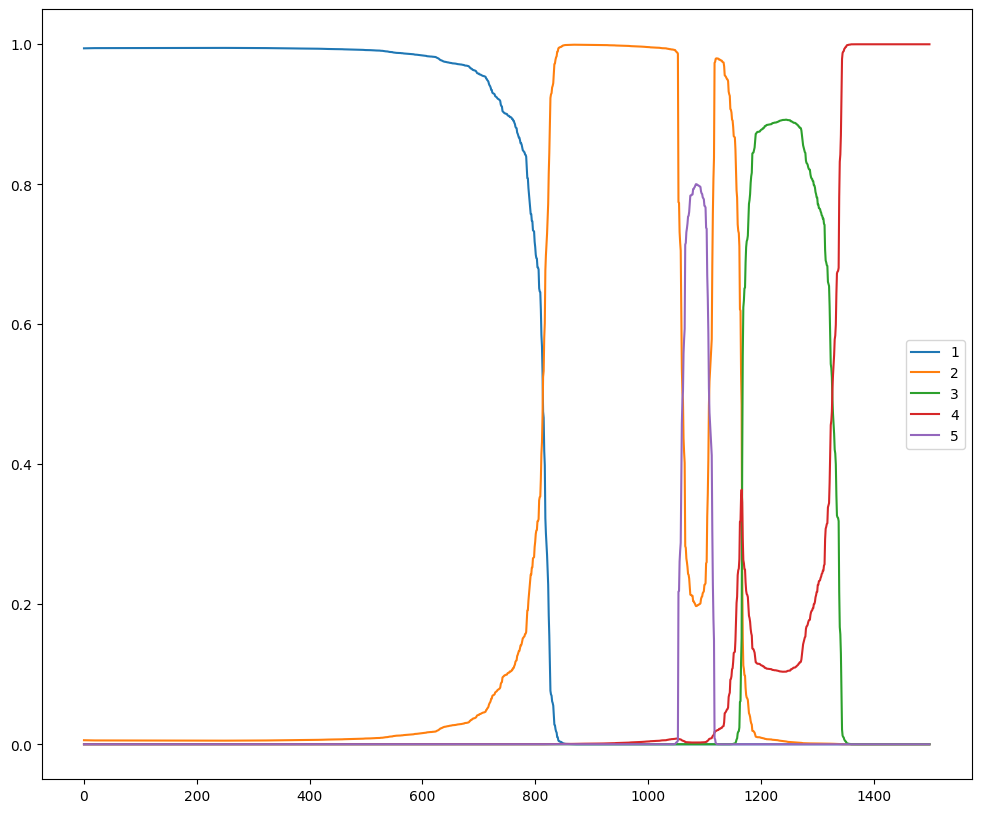

[[ 4320.08799415  8616.56640229 14575.68402591 18886.60479687
  10194.00446732]]



In [334]:
plt.figure(figsize=(12, 10))

plt.plot(zig[:, 0], label='1')
plt.plot(zig[:, 1], label='2')
plt.plot(zig[:, 2], label='3')
plt.plot(zig[:, 3], label='4')
plt.plot(zig[:, 4], label='5')
plt.legend()
plt.show()
print(mug)
print()

[ 4320.08799415  8616.56640229 14575.68402591 18886.60479687
 10194.00446732]


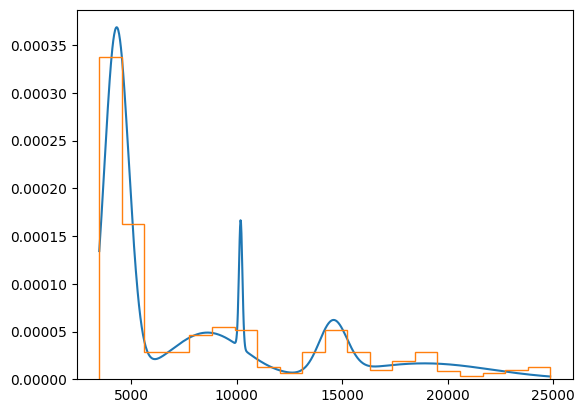

In [335]:
muggy = np.array(mug[0])
print(muggy)


x = np.linspace(np.min(outliers), np.max(outliers), 1000)
gauss = 0
for i in range(len(muggy)):
    gauss += np.exp(-0.5*((x - muggy[i])**2/(Sig[i][0][0])))/np.sqrt(2*np.pi*Sig[i][0][0])*pig[i]

plt.plot(x, gauss)
plt.hist(outliers, bins='auto', histtype='step', density=True)
plt.yscale('linear')
plt.xlabel('')
plt.show()

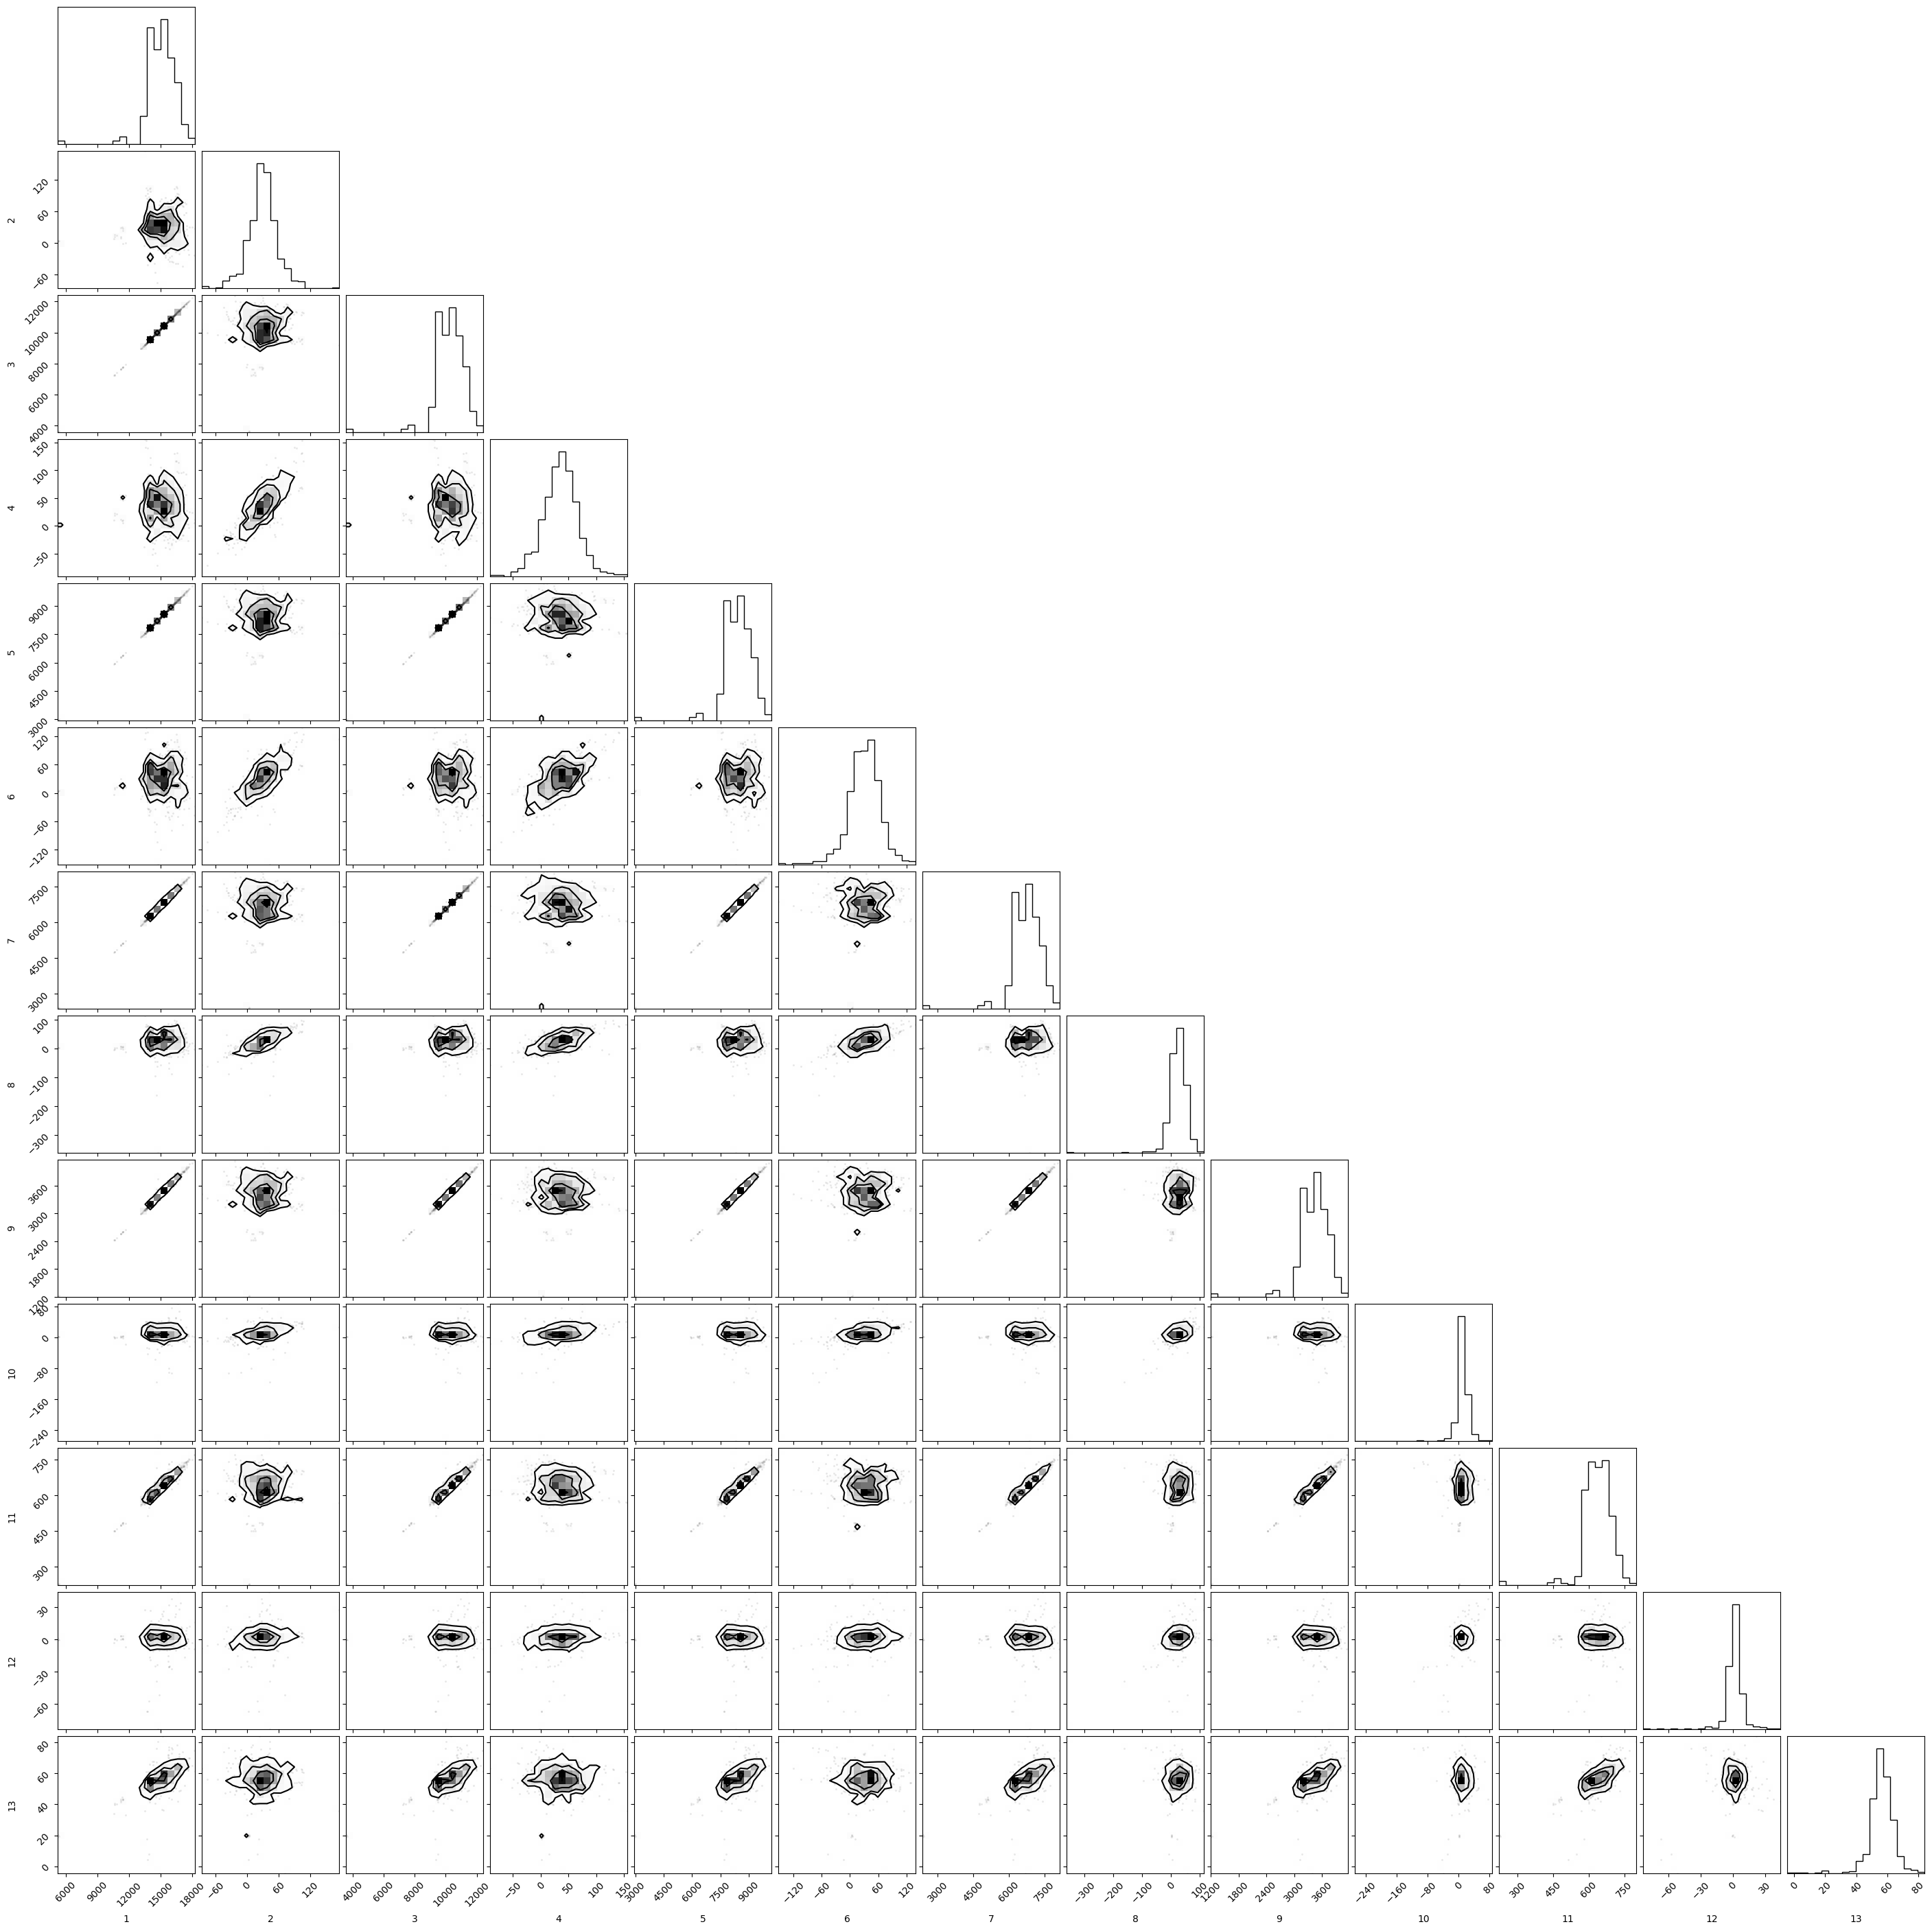

In [336]:
c0 = np.load('Data/p0_coefficients.npy')
c1 = np.load('Data/p1_coefficients.npy')
c2 = np.load('Data/p2_coefficients.npy')
c3 = np.load('Data/p3_coefficients.npy')
c4 = np.load('Data/p4_coefficients.npy')

coeffs = np.concatenate((c0, c1, c2, c3))
labels = np.arange(1, 14)
figure = corner.corner(coeffs, labels=labels)


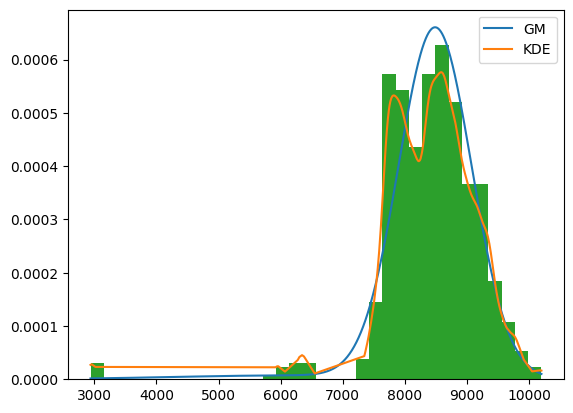

In [337]:
def gauss_kern(data, smooth=0.1):
    fit_func = 0

    for x in data:
        fit_func += np.exp(-0.5*((data - x)/(np.std(data)*smooth))**2)
    
    return fit_func/np.trapezoid(fit_func, data)

term = 5

pig1, mug1, Sig1, zig1, ng1 = do_EM(np.vstack(coeffs.T[term-1]), Niter=int(1e5), Ng=2)

muggy = mug1[0]
x = np.linspace(np.min(coeffs.T[term-1]), np.max(coeffs.T[term-1]), 1000)
gauss = 0
for i in range(len(muggy)):
    gauss += np.exp(-0.5*((x - muggy[i])**2/(Sig1[i][0][0])))/np.sqrt(2*np.pi*Sig1[i][0][0])*pig1[i]

plt.plot(x, gauss, label='GM')
plt.plot(np.sort(coeffs.T[term-1]), gauss_kern(np.sort(coeffs.T[term-1])), label='KDE')
plt.legend()
plt.hist(coeffs.T[term-1], bins='auto', density=True)
plt.xlabel('5th fit coefficient')
plt.yscale('linear')
plt.xlabel('')
plt.show()

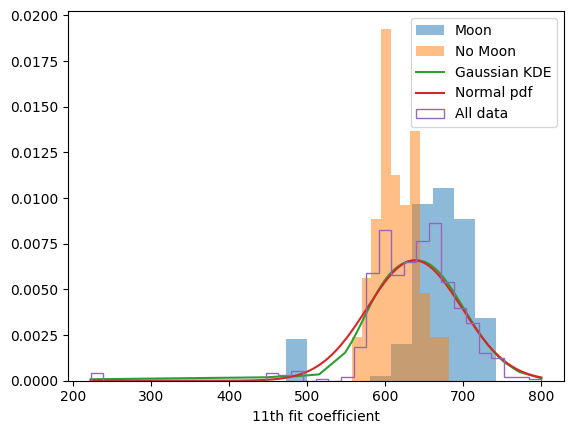

In [338]:



def para_kern(data, smooth=1000):
    fit_func = 0

    for x in data:
        fit_func += np.where(-(data - x)**2/np.std(data)/smooth + 1 > 0,
                             -(data - x)**2/np.std(data)/smooth + 1, 0)
    
    return fit_func/np.trapezoid(fit_func, data)

term=11


moon_coeffs = np.concatenate((coeffs.T[term-1][500:600], coeffs.T[term-1][:30]))
plt.hist(moon_coeffs, density=True, alpha=0.5, label='Moon')
plt.hist(coeffs.T[term-1][200:300], density=True, alpha=0.5, label='No Moon')




x = np.linspace(np.min(coeffs.T[term - 1]), np.max(coeffs.T[term-1]), 1000)
plt.plot(np.sort(coeffs.T[term-1]), gauss_kern(np.sort(coeffs.T[term-1]), smooth=0.5), label='Gaussian KDE')
plt.plot(x, np.exp(-(x-np.mean(coeffs.T[term-1]))**2/(2*np.std(coeffs.T[term-1])**2))/np.sqrt(2*np.pi*np.std(coeffs.T[term-1])**2), label='Normal pdf')
plt.hist(coeffs.T[term-1], bins='auto', density=True, histtype='step', label='All data')
plt.legend()
plt.yscale('linear')
plt.xlabel('11th fit coefficient')
plt.ylabel('')
plt.show()

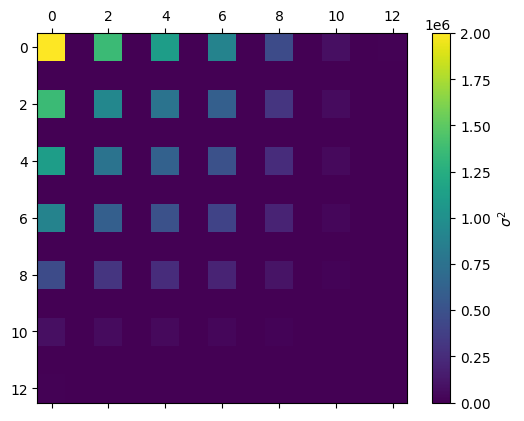

In [339]:
coeff_cov = np.cov(coeffs.T)
fig, ax = plt.subplots()
im = ax.matshow(coeff_cov)
fig.colorbar(im, ax=ax, label=r'$\sigma^2$')

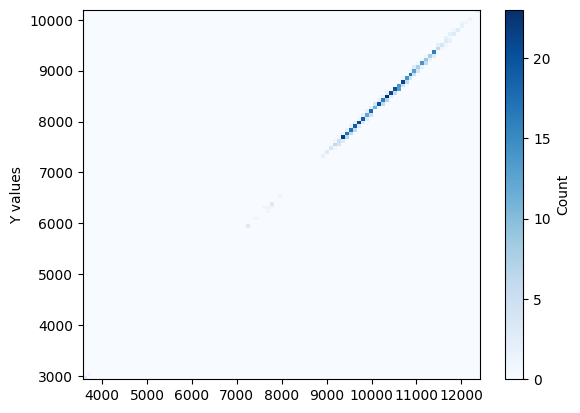

In [340]:
plt.hist2d(coeffs.T[3-1], coeffs.T[3+1], bins=(100, 100), cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel(r'')
plt.ylabel('Y values')
plt.show()

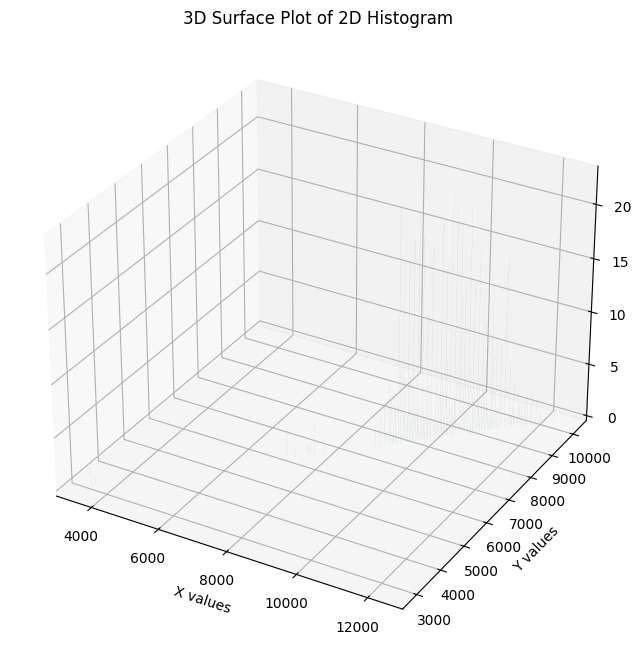

In [341]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

term=3
# Generate sample data
x, y = coeffs.T[term-1], coeffs.T[term+1]

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=100)

# Create grid for 3D surface
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Set bar widths and depths
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.flatten()

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot as 3D bars (for histogram-like appearance)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='skyblue', zsort='average')

# Or plot as a surface (for smoother appearance)
# X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
# ax.plot_surface(X, Y, hist.T, cmap='viridis')

ax.set_xlabel('X values')
ax.set_ylabel('Y values')
ax.set_zlabel('Frequency')
plt.title('3D Surface Plot of 2D Histogram')
plt.show()

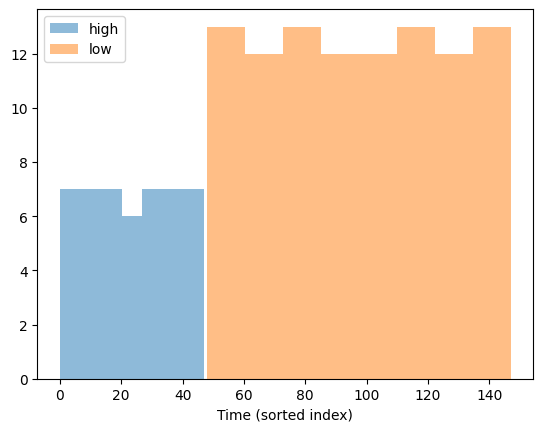

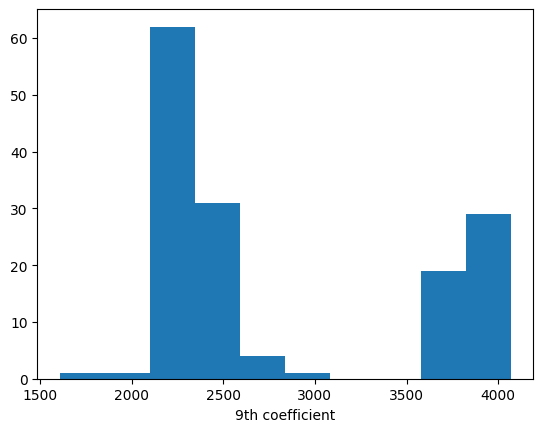

In [342]:
high=[]
low=[]
term=9
for i in range(len(c4.T[term-1])):
    if c4.T[term-1][i] > 3500:
        high.append(i)
    else:
        low.append(i)

plt.hist(high, alpha=0.5, bins='auto', label='high')
plt.hist(low, alpha=0.5, bins='auto', label='low')
plt.xlabel('Time (sorted index)')
plt.legend()
plt.show()

plt.hist(c4.T[term-1])
plt.xlabel("9th coefficient")
plt.show()